In [1]:
import tensorflow as tf

In [2]:
import cv2

In [3]:
import pickle

In [5]:
import os 
import PIL

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import files
uploaded = files.upload()

Saving emotion.csv to emotion.csv


In [8]:
emotion_df = pd.read_csv('emotion.csv')

In [9]:
emotion_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...


In [10]:
# function to convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [12]:
emotion_df['pixels'] = emotion_df[' pixels'] # String format

In [13]:
emotion_df['pixels'] = emotion_df['pixels'].apply(lambda x: string2array(x))

In [14]:
emotion_df['pixels'][2].shape

(48, 48, 1)

In [15]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

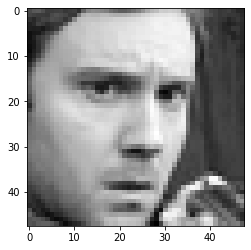

In [16]:
plt.imshow(emotion_df['pixels'][0].squeeze(), cmap = 'gray')

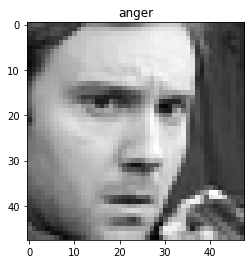

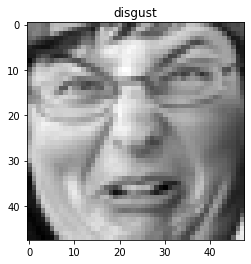

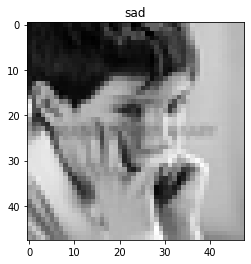

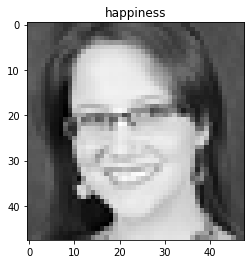

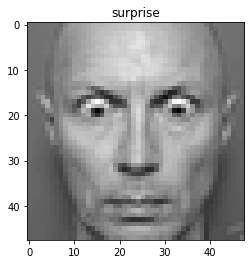

In [17]:
emotions = [0,1,2,3,4]

for i in emotions:
  data = emotion_df[emotion_df['emotion'] == i][:1]
  img = data['pixels'].item()
  img = img.reshape(48,48)
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap= 'gray')

In [18]:
X = emotion_df['pixels']
X.shape

(24568,)

In [19]:
# split the dataframe to features and labels
# from keras.utils import to_categorical

X = emotion_df['pixels']
# y = to_categorical(emotion_df['emotion'])
y = pd.get_dummies(emotion_df['emotion'])

X = np.stack(X, axis = 0)
X = X.reshape(24568, 48, 48, 1)

print(X.shape, y.shape)

(24568, 48, 48, 1) (24568, 5)


In [20]:
X = np.array(X)
y = np.array(y)

In [21]:
# spliting the dataframe in to train,test and validation data frames

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X,y,test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test,y_Test, test_size = 0.5, shuffle = True)


In [22]:
print(X_val.shape, y_val.shape)

(1228, 48, 48, 1) (1228, 5)


In [23]:
print(X_Test.shape, y_Test.shape)

(1229, 48, 48, 1) (1229, 5)


In [24]:
print(X_train.shape, y_train.shape)

(22111, 48, 48, 1) (22111, 5)


In [25]:
# image pre-processing

X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [26]:
train_datagen = ImageDataGenerator(
rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode = "nearest"
)


Text(0.5, 1.0, 'Number of images per emotion')

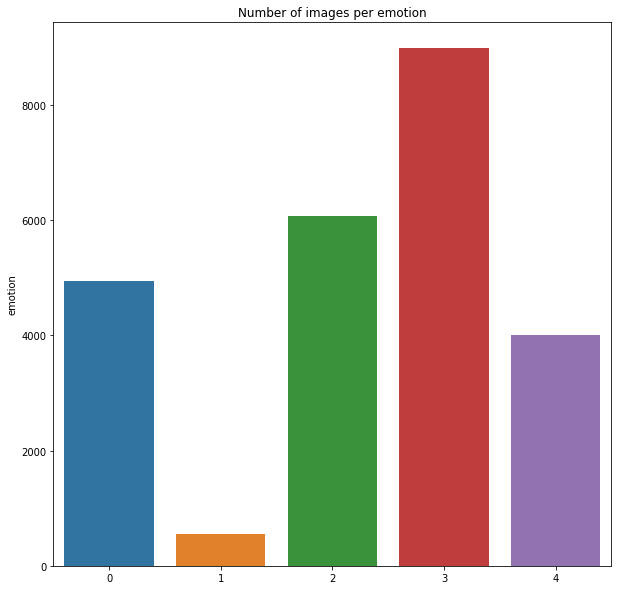

In [27]:
plt.figure(figsize = (10, 10))
sns.barplot(x = emotion_df.emotion.value_counts().index, y = emotion_df.emotion.value_counts() )
plt.title('Number of images per emotion')

In [28]:
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [29]:
input_shape = (48, 48, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - stage
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2, 2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [30]:
# train the network
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [31]:
# Recall that the first facial key points model was saved as follows: FacialKeyPoints_weights.hdf5 and FacialKeyPoints-model.json

# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [45]:
history = model_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 50, callbacks=[checkpointer, earlystopping])

Epoch 1/50
345/345 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.7609
Epoch 00001: val_loss did not improve from 0.77885
345/345 [==============================] - 16s 46ms/step - loss: 0.6192 - accuracy: 0.7609 - val_loss: 1.1724 - val_accuracy: 0.5635
Epoch 2/50
345/345 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.7683
Epoch 00002: val_loss did not improve from 0.77885
345/345 [==============================] - 16s 46ms/step - loss: 0.6066 - accuracy: 0.7683 - val_loss: 0.8106 - val_accuracy: 0.6865
Epoch 3/50
344/345 [============================>.] - ETA: 0s - loss: 0.5917 - accuracy: 0.7696
Epoch 00003: val_loss did not improve from 0.77885
345/345 [==============================] - 16s 46ms/step - loss: 0.5914 - accuracy: 0.7698 - val_loss: 0.9198 - val_accuracy: 0.6653
Epoch 4/50
345/345 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.7736
Epoch 00004: val_loss did not improve from 0.77885
345/345 [====

In [46]:
# saving the model architecture to json file for future use

model_json = model_emotion.to_json()
with open("Emotion-model.json","w") as json_file:
  json_file.write(model_json)

In [47]:
with open('Emotion-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_emotion = tf.keras.models.model_from_json(json_savedModel)
model_emotion.load_weights('FacialExpression_weights.hdf5')
model_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [48]:
score = model_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 0s 9ms/step - loss: 0.7414 - accuracy: 0.7201
Test Accuracy: 0.7200976610183716


In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

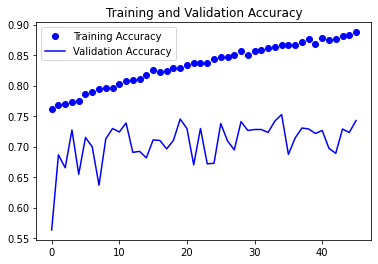

In [51]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

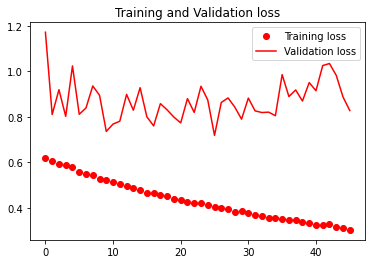

In [52]:
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

In [53]:
predicted_classes = np.argmax(model_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

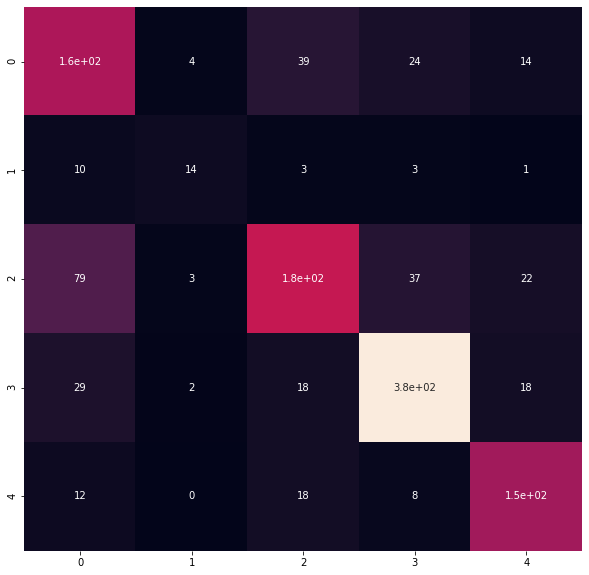

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

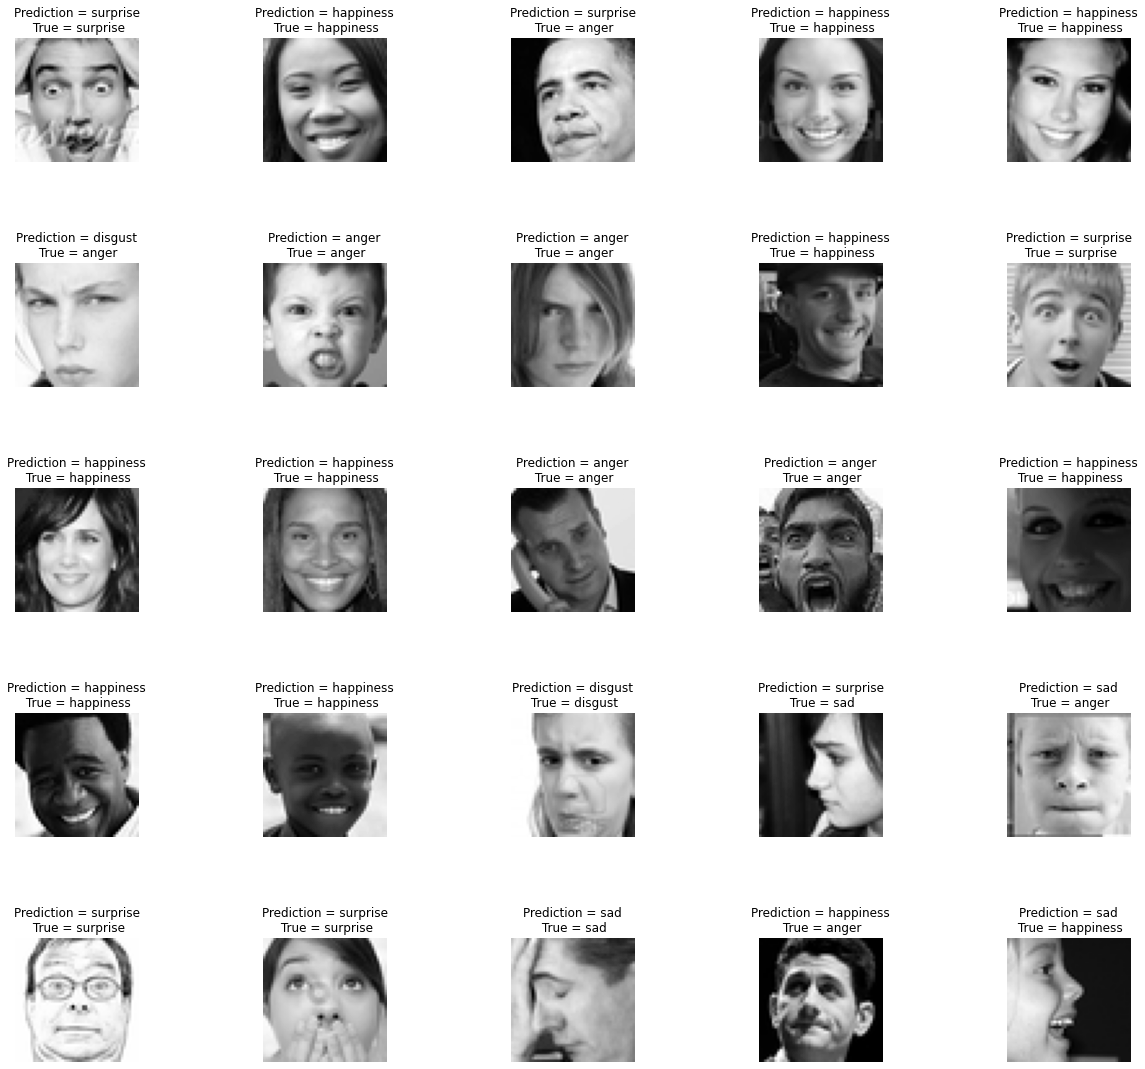

In [55]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (20, 20))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_Test[i].reshape(48,48), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)   